# Trains and  tests on parts of  NA12878 data for Del_st, Del_end and No_sv

## Load dependences and setting output configuration

In [1]:
import numpy as np
from keras.utils.np_utils import to_categorical
import keras
%pylab inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


## Load data from npy files

In [2]:
window_size = 200

In [3]:
datapath = 'F:/1_GTCG/data/TestData_060818.tar/TestData_060818/NA12878' 

germline_1_datapath = datapath + '/ChannelData/unzipped/'
ger_1_labels_datapath = datapath + '/LabelData/unzipped/'

G1_data_SV = np.empty([0, 27, window_size])
G1_labels_SV =[]
G1_data_noSV = np.empty([0, 27, window_size])
G1_labels_noSV =[]

for i in range(1,18,1):
        G1_data_new =np.load(germline_1_datapath + str(i) + '_channel_maker_real_germline.npy/' + str(i) +'_channel_maker_real_germline.npy')
        G1_labels_new = np.load(ger_1_labels_datapath  +  str(i) +'_label_ci_full_overlap.npy/' +str(i) +'_label_ci_full_overlap.npy') 
        G1_data_new = G1_data_new[np.where(G1_labels_new != 'UK')]
        G1_labels_new = G1_labels_new[np.where(G1_labels_new != 'UK')]
        G1_data_SV_new  = G1_data_new[np.where(G1_labels_new != 'noSV')]
        G1_labels_SV_new  = G1_labels_new[np.where(G1_labels_new != 'noSV')]
        n_windows_sv = G1_data_SV_new.shape[0]
        G1_data_noSV_new  = G1_data_new[np.where(G1_labels_new == 'noSV')]
        G1_labels_noSV_new  = G1_labels_new[np.where(G1_labels_new == 'noSV')]
        G1_data_noSV_new =  G1_data_noSV_new[0:n_windows_sv]
        G1_labels_noSV_new =  G1_labels_noSV_new[0:n_windows_sv]
        print(str(i) + ':' + str(G1_data_SV_new.shape))
        print(G1_labels_SV_new[0])
        G1_data_SV = np.concatenate((G1_data_SV, G1_data_SV_new))
        G1_labels_SV = np.concatenate((G1_labels_SV, G1_labels_SV_new))
        G1_data_noSV = np.concatenate((G1_data_noSV, G1_data_noSV_new))
        G1_labels_noSV = np.concatenate((G1_labels_noSV, G1_labels_noSV_new))

1:(537, 27, 200)
DEL_start
2:(540, 27, 200)
DEL_start
3:(411, 27, 200)
DEL_start
4:(489, 27, 200)
DEL_start
5:(441, 27, 200)
DEL_start
6:(461, 27, 200)
DEL_start
7:(453, 27, 200)
DEL_start
8:(358, 27, 200)
DEL_start
9:(293, 27, 200)
DEL_start
10:(282, 27, 200)
DEL_start
11:(332, 27, 200)
DEL_start
12:(296, 27, 200)
DEL_start
13:(208, 27, 200)
DEL_start
14:(208, 27, 200)
DEL_start
15:(173, 27, 200)
DEL_start
16:(360, 27, 200)
DEL_start
17:(205, 27, 200)
DEL_start


### Find  the indexes that split the categories

In [4]:
def find_splitting_indices(labels):
    for i in range (0, labels.shape[0] - 1):
        if (labels[i] != labels[i+1]):
            print(i , ': ', labels[i] , labels[i+1] )        

In [5]:
#find_splitting_indices(G1_labels)

In [6]:
#G1_labels_SV = ['DEL'] * G1_labels_SV.shape[0]

In [5]:
sv=G1_data_SV.shape[0]

In [6]:
sv

6047

In [7]:
int(sv/2)

3023

In [8]:
G1_data_noSV  = G1_data_noSV[0:int(sv/2)] 

In [9]:
G1_labels_noSV  =G1_labels_noSV[0:int(sv/2)] 

In [10]:
SV_train = 4000
noSV_train = 2000
SV_val = 1000
noSV_val = 500

In [11]:
X_train = np.concatenate((G1_data_SV[0:SV_train], G1_data_noSV[0:noSV_train ]))
X_val = np.concatenate((G1_data_SV[SV_train:SV_train+SV_val], G1_data_noSV[noSV_train:noSV_train +noSV_val ]))
X_test = np.concatenate((G1_data_SV[SV_train+SV_val:], G1_data_noSV[noSV_train +noSV_val:]))

In [12]:
y_train = np.concatenate((G1_labels_SV[0:SV_train], G1_labels_noSV[0:noSV_train ]))
y_val = np.concatenate((G1_labels_SV[SV_train:SV_train+SV_val], G1_labels_noSV[noSV_train:noSV_train +noSV_val ]))
y_test = np.concatenate((G1_labels_SV[SV_train+SV_val:], G1_labels_noSV[noSV_train +noSV_val:]))

### Number of training, validation and test windows

In [13]:
X_train.shape

(6000, 27, 200)

In [14]:
X_val.shape

(1500, 27, 200)

In [15]:
X_test.shape

(1570, 27, 200)

In [16]:
y_test.shape

(1570,)

In [17]:
number_channels = X_train.shape[1]
number_channels

27

## Normalize data using the reads coverage as parameter and remove uninteresting channels for deletions

In [18]:
coverage = np.median(X_train[:, 0, :]) #the median of the coverage in the normal cells
coverage


37.0

In [19]:
def normalize(X):       
    for i in range (0, len(X)):                              
        for j in range(0,number_channels):                                                                                            
            X[i][j] = np.divide(X[i][j], coverage)*100 
normalize(X_train)
normalize(X_val)
normalize(X_test)

In [20]:
def eliminate_noise_chanels(X):
    return np.delete(X, [4-1,5-1,6-1,7-1,8-1,9-1,10-1,12-1,13-1,15-1,16-1, 17-1,18-1,19-1,23-1,24-1,26-1,27-1], axis=1)
    

In [21]:
def eliminate_distance_chanels(X):
    return np.delete(X, [3,4,7,8], axis=1)

In [22]:
X_train = eliminate_noise_chanels(X_train)
X_val = eliminate_noise_chanels(X_val)
X_test = eliminate_noise_chanels(X_test)

In [23]:
X_train = eliminate_distance_chanels(X_train)
X_val = eliminate_distance_chanels(X_val)
X_test = eliminate_distance_chanels(X_test)

In [24]:
X_train.shape

(6000, 5, 200)

In [33]:
number_channels = X_train.shape[1]
number_channels

5

## Differentiate the time series for a zero mean

In [43]:
def differentiate(X):
    for i in range(0, X.shape[0]):        
        for j in range(0, X.shape[1]):
            for k in range(0, X.shape[2]-1):
                X[i][j][k] = X[i][j][k+1] - X[i][j][k]
    return X[:,:,:-1]        

In [44]:
X_train = differentiate(X_train)

In [45]:
X_val = differentiate(X_val)
X_test = differentiate(X_test)

## Plots several  windows

In [46]:
n_windows = 100
label = ["None"] * number_channels

In [47]:
label[0] = "germline:coverage"
label[1] = "germline:#left clipped reads"
label[2] = "germline:#right clipped reads"
label[3] = "germline:#split reads right split"
label[4] = "germline:#split reads left split"

In [48]:
from numpy import *
import math
import matplotlib.pyplot as plt

colors =['b','g', 'm', 'gray', 'r','c', 'darkgreen' ,'y', 'k', 'orange', 'gray']

def plot_channels(start_window, n_windows):
    for i in range (start_window, start_window + n_windows, 1):
        #print(y_train[i], 'id:', i)
        print('id:', i)
        print('Nanopore:', y_test[i])#, '. DeepSV:', labels[predicted[i]])
        for j in range (0, number_channels):   
            shift = 0
            start =0
            if j in [0,11]:
                shift = -100
            if j > 8:
                start = -60
            Z = [start + shift + 300 + x - 5*j*4 for x in X_test[i][j]]  
            plt.ylim([150,450])
            if np.max(Z) > 1000:
                plt.ylim([-200,1000])
                Z = [start + shift + 300 + x - 5*j*4 - 400 for x in X_test[i][j]]  
            if j>8:
                plt.plot(Z,  label = label[j], linestyle=':', linewidth=1.5, color = colors[j % 9])
            else:
                plt.plot(Z,  label = label[j], color = colors[j])
        
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 10})    
        plt.show()

id: 0
Nanopore: DEL_start


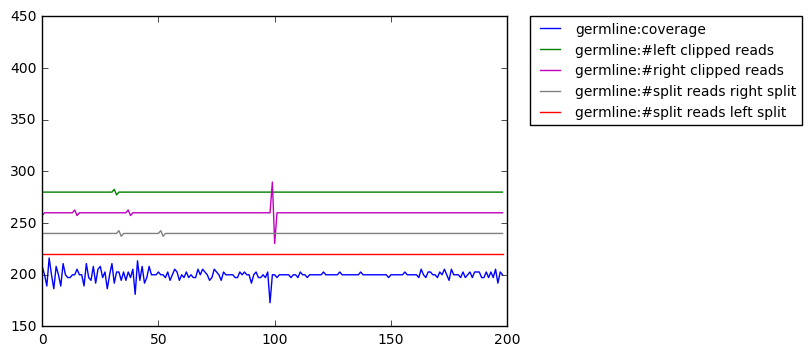

id: 1
Nanopore: DEL_end


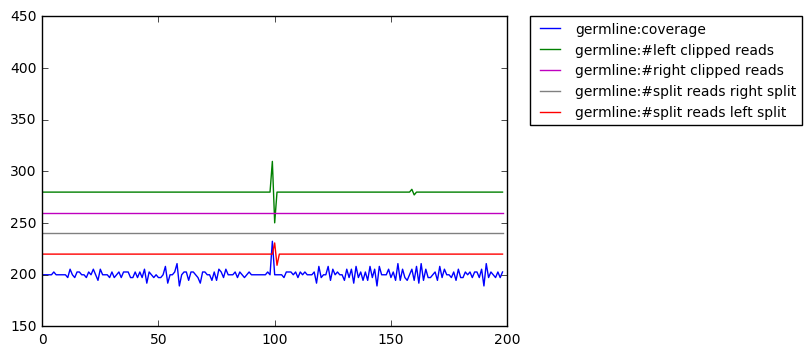

id: 2
Nanopore: DEL_start


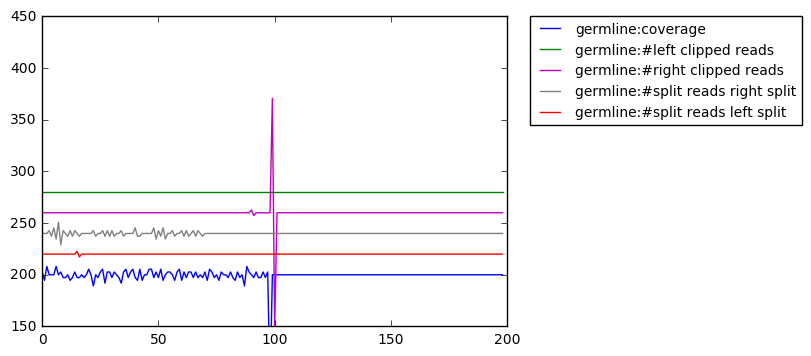

id: 3
Nanopore: DEL_end


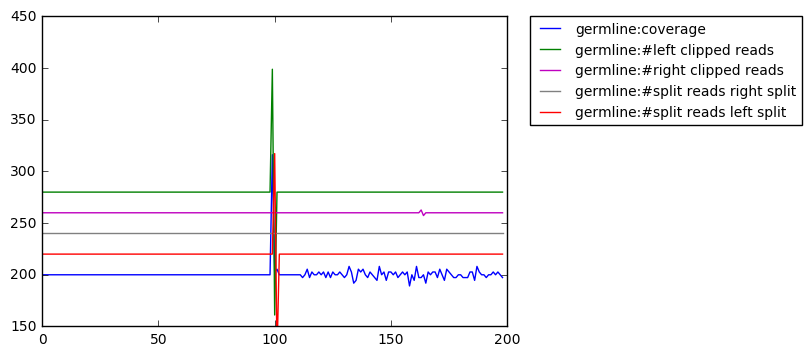

id: 4
Nanopore: DEL_end


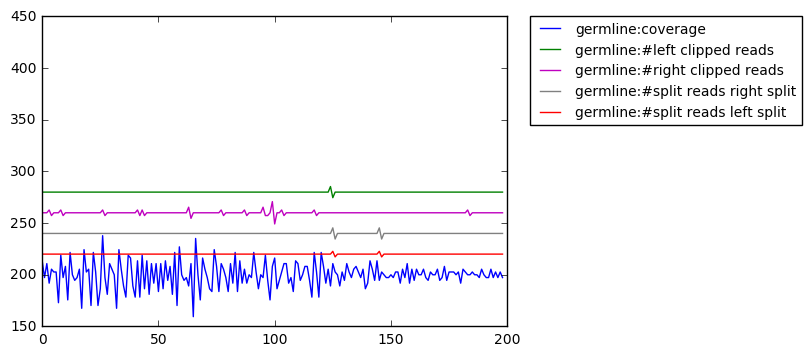

id: 5
Nanopore: DEL_start


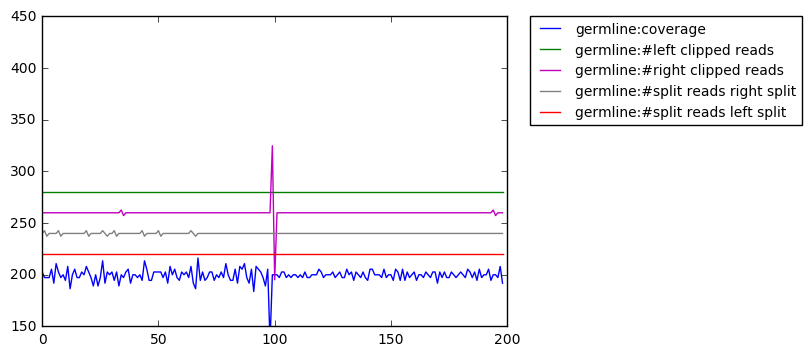

id: 6
Nanopore: DEL_end


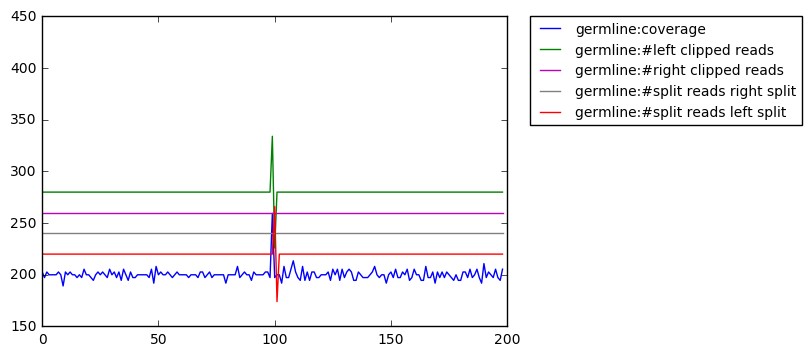

id: 7
Nanopore: DEL_start


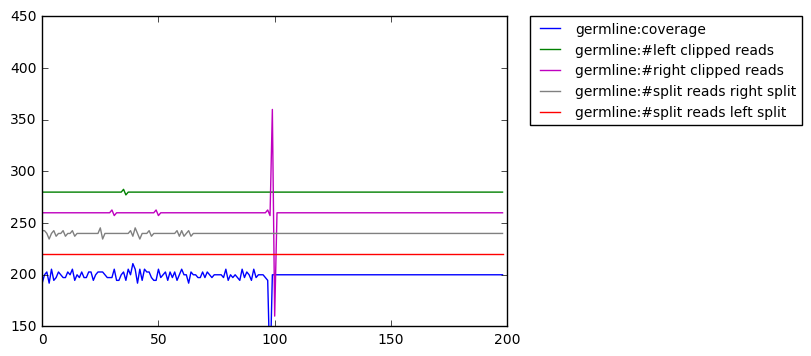

id: 8
Nanopore: DEL_end


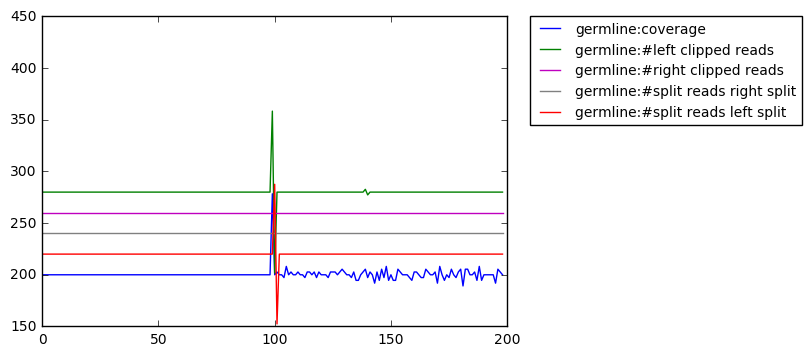

id: 9
Nanopore: DEL_start


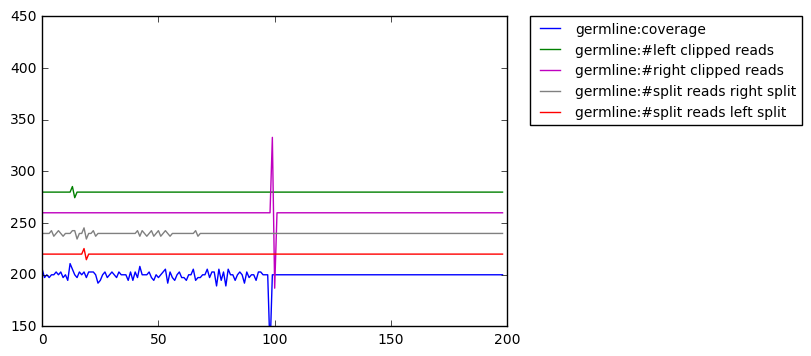

id: 10
Nanopore: DEL_end


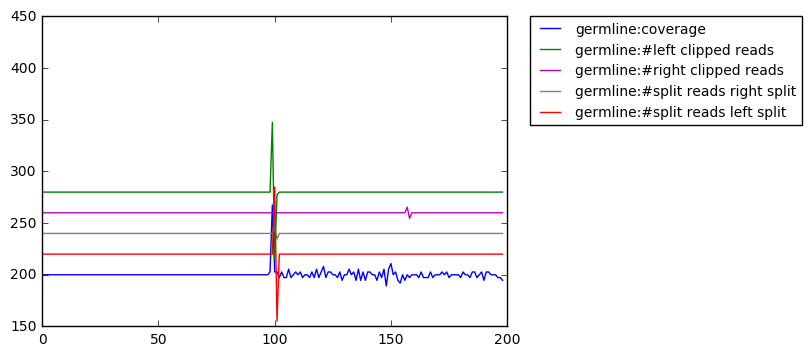

id: 11
Nanopore: DEL_start


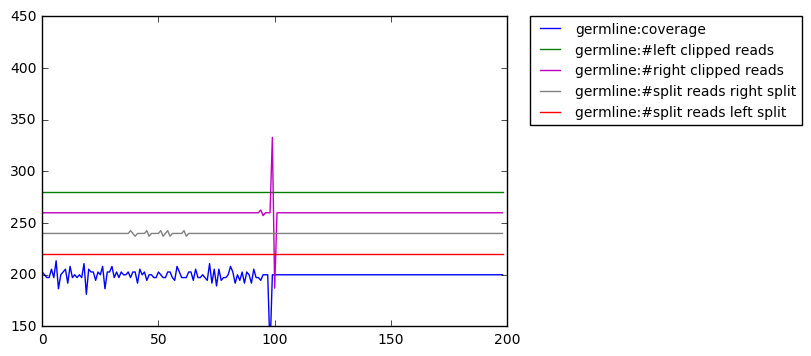

id: 12
Nanopore: DEL_end


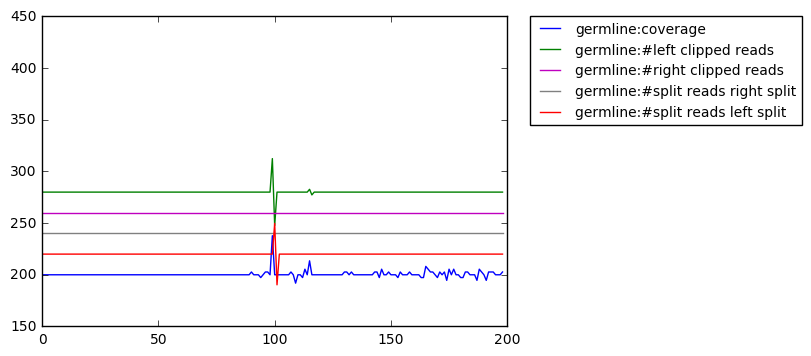

id: 13
Nanopore: DEL_start


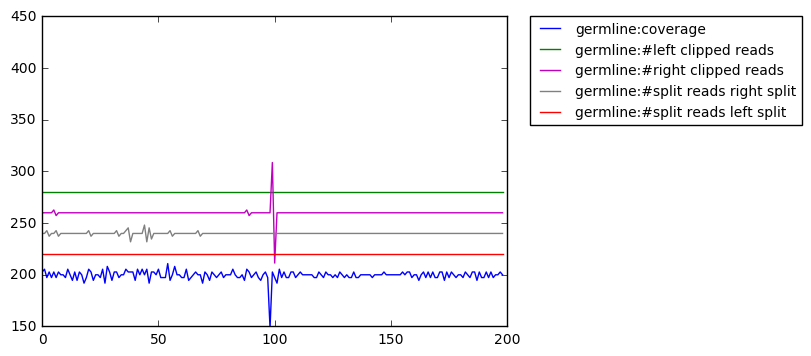

id: 14
Nanopore: DEL_end


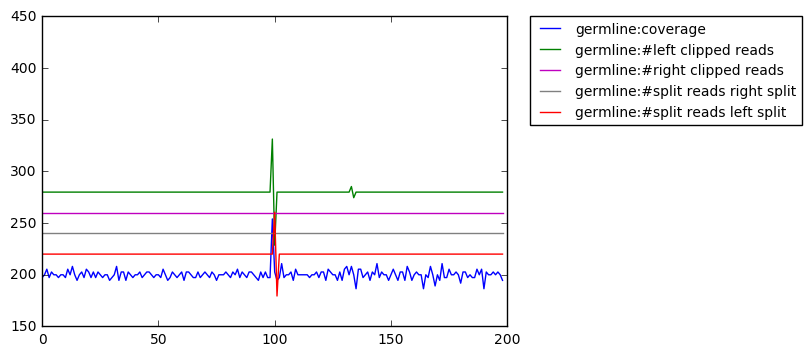

id: 15
Nanopore: DEL_end


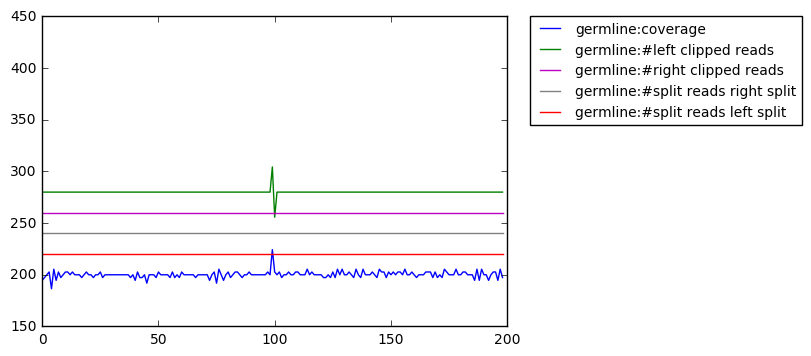

id: 16
Nanopore: DEL_start


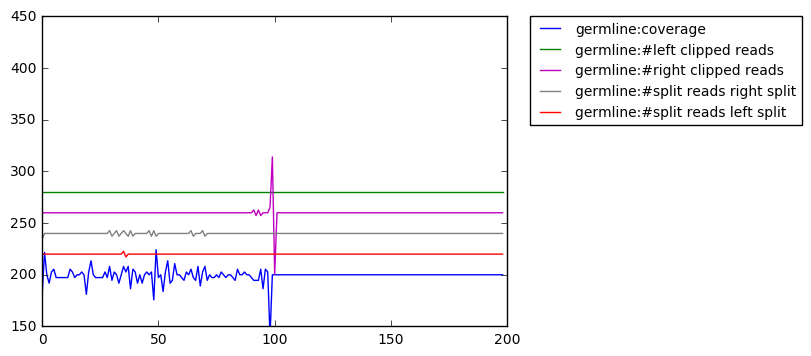

id: 17
Nanopore: DEL_end


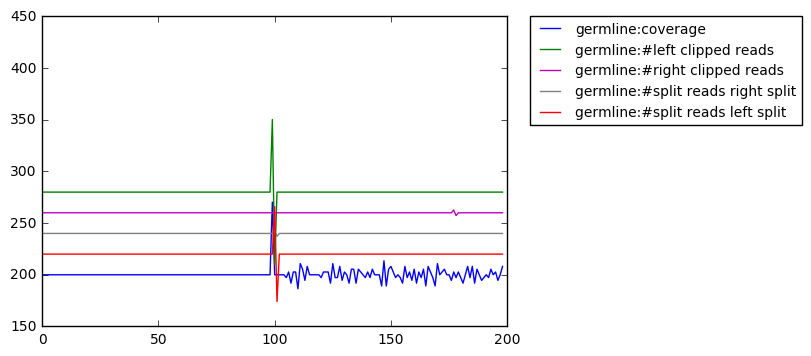

id: 18
Nanopore: DEL_start


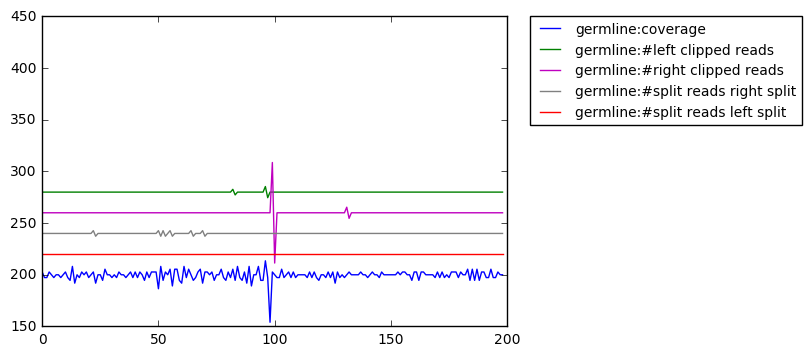

id: 19
Nanopore: DEL_start


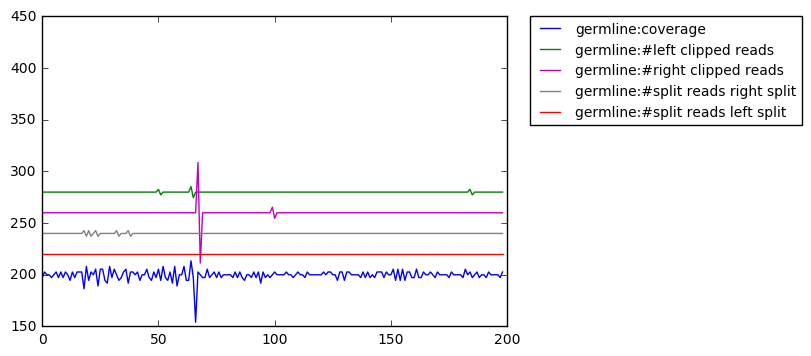

In [49]:
start_window = 0
n_windows = 20
plot_channels(start_window, n_windows)

id: 1200
Nanopore: noSV


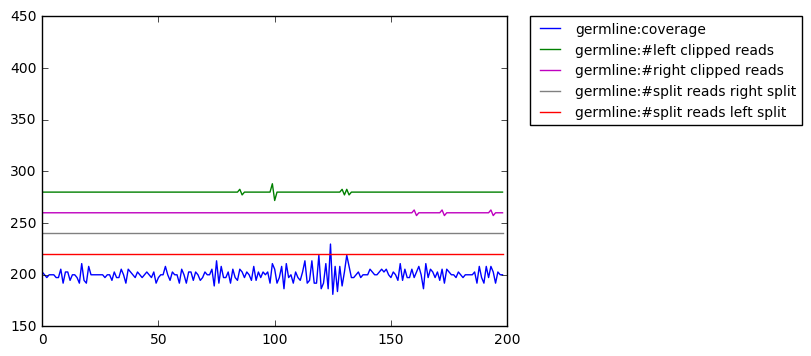

id: 1201
Nanopore: noSV


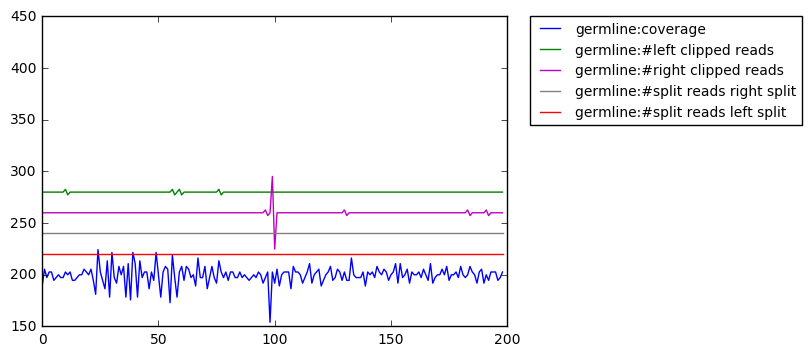

id: 1202
Nanopore: noSV


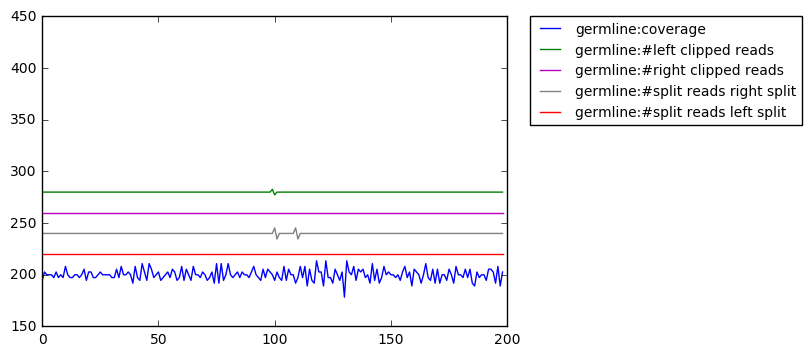

id: 1203
Nanopore: noSV


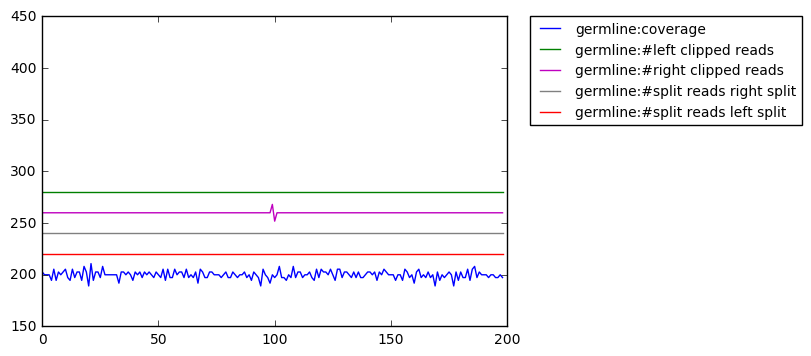

id: 1204
Nanopore: noSV


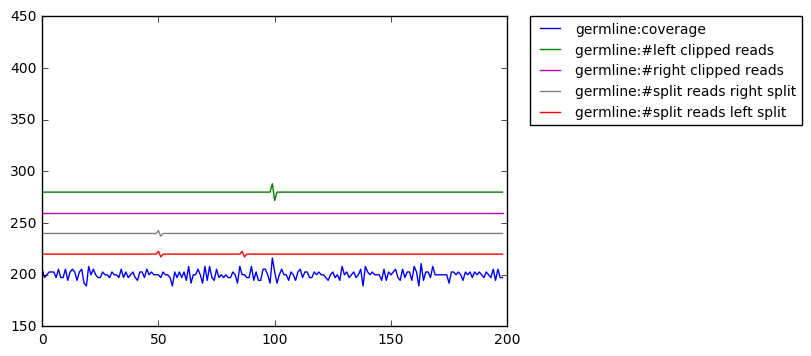

id: 1205
Nanopore: noSV


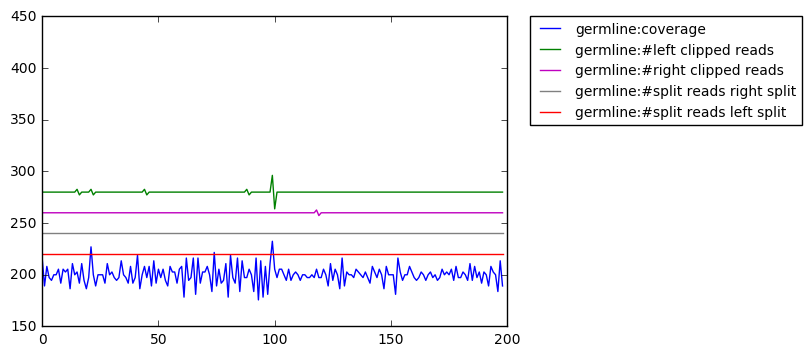

id: 1206
Nanopore: noSV


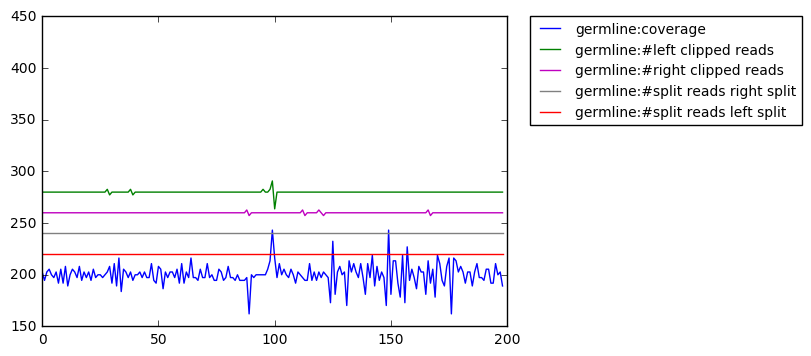

id: 1207
Nanopore: noSV


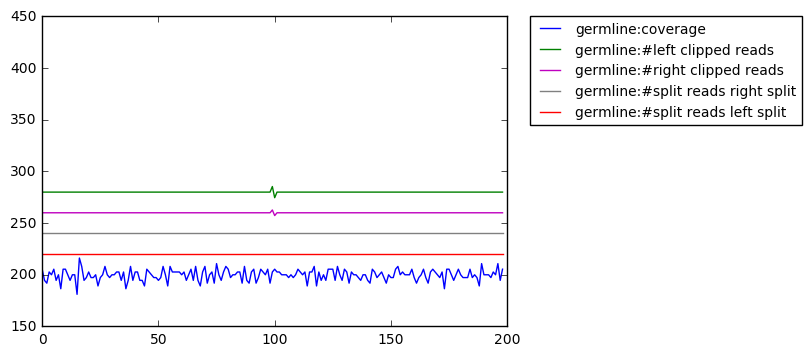

id: 1208
Nanopore: noSV


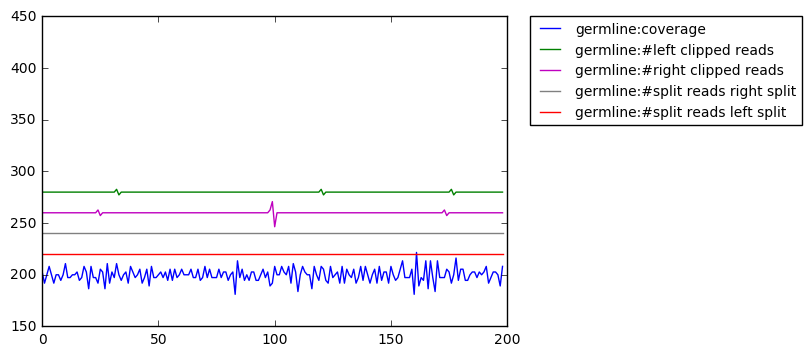

id: 1209
Nanopore: noSV


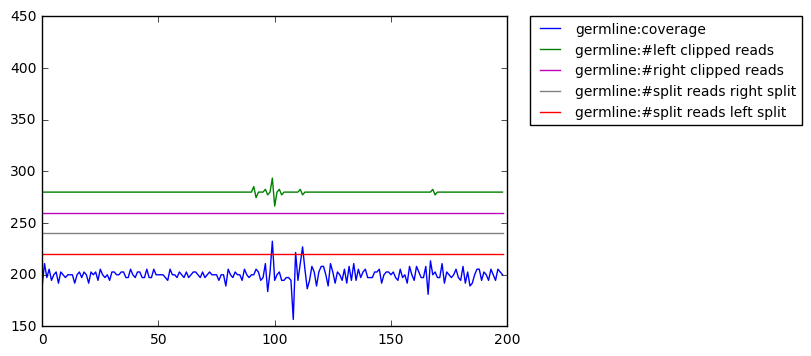

id: 1210
Nanopore: noSV


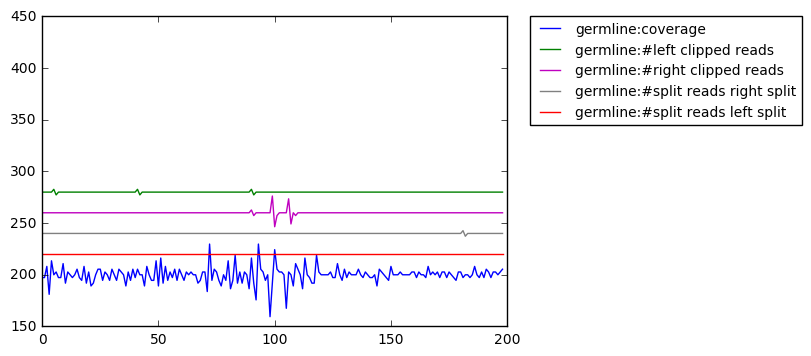

id: 1211
Nanopore: noSV


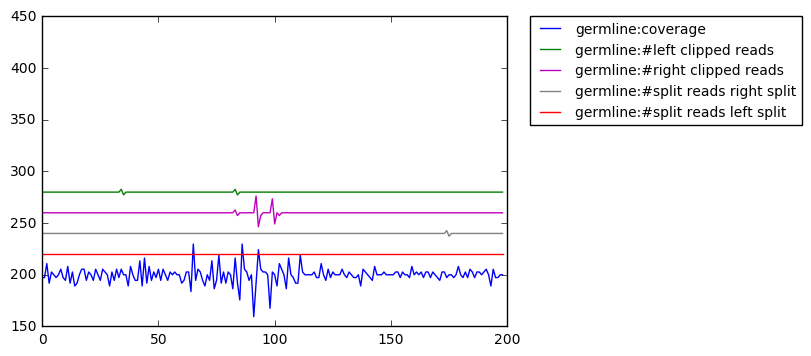

id: 1212
Nanopore: noSV


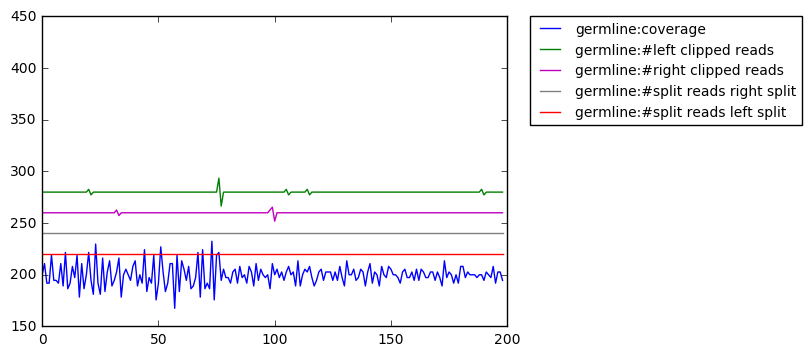

id: 1213
Nanopore: noSV


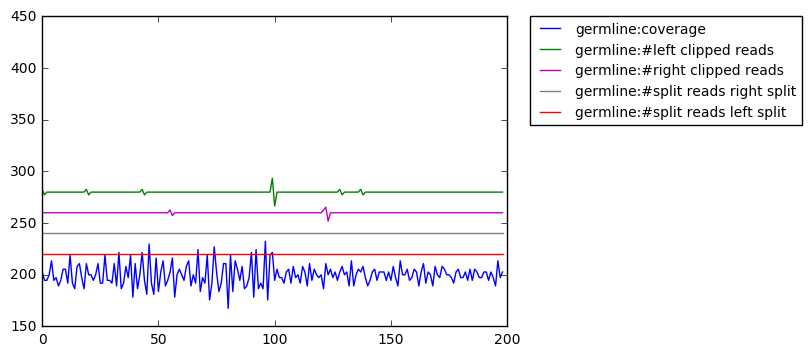

id: 1214
Nanopore: noSV


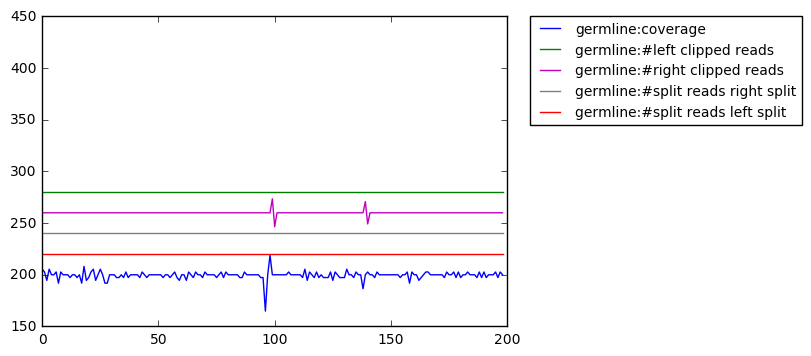

id: 1215
Nanopore: noSV


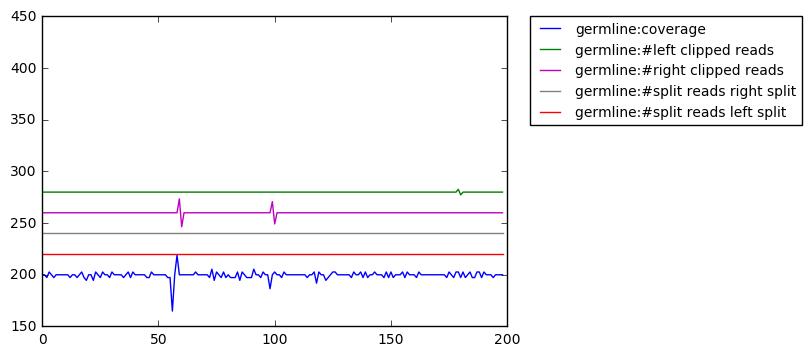

id: 1216
Nanopore: noSV


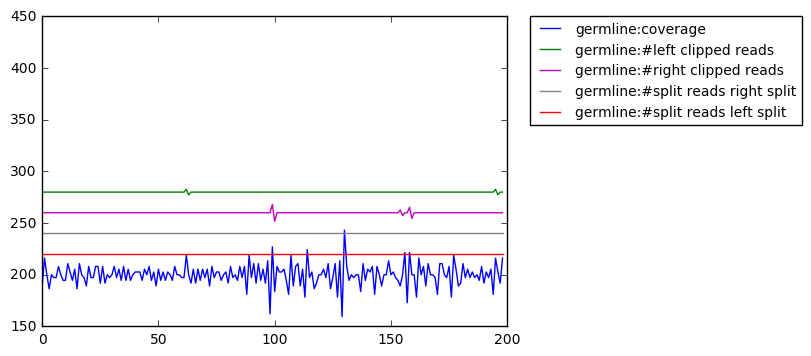

id: 1217
Nanopore: noSV


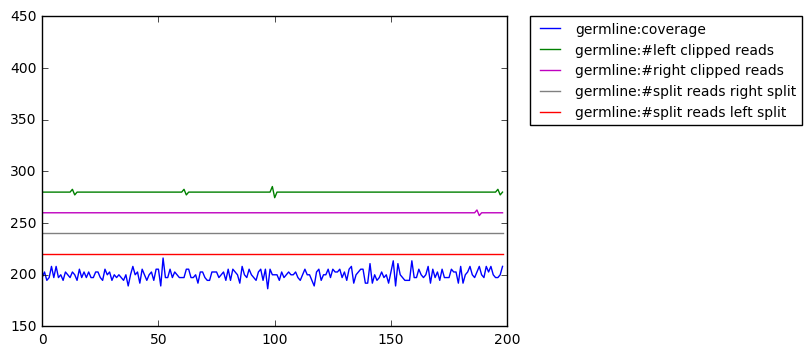

id: 1218
Nanopore: noSV


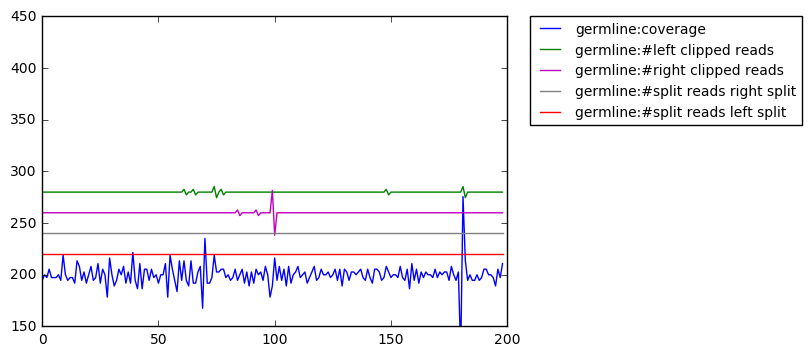

id: 1219
Nanopore: noSV


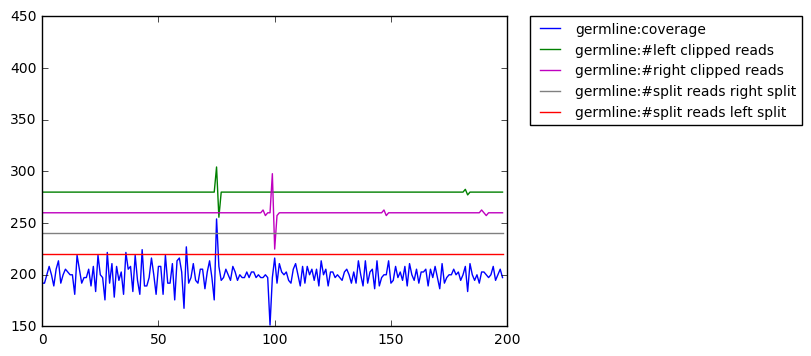

id: 1220
Nanopore: noSV


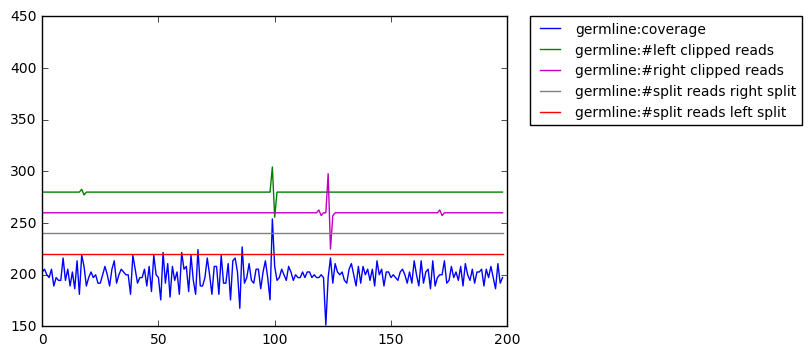

id: 1221
Nanopore: noSV


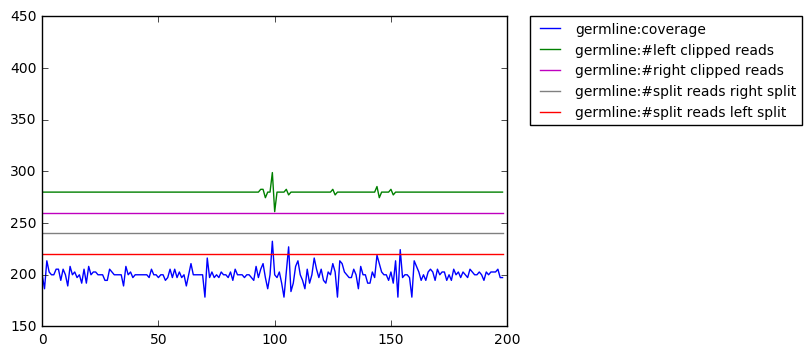

id: 1222
Nanopore: noSV


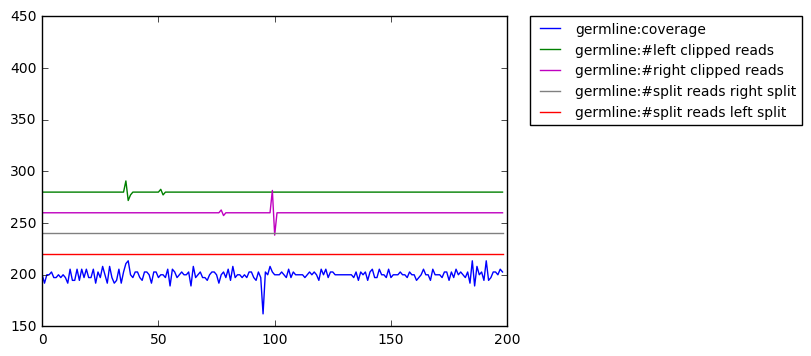

id: 1223
Nanopore: noSV


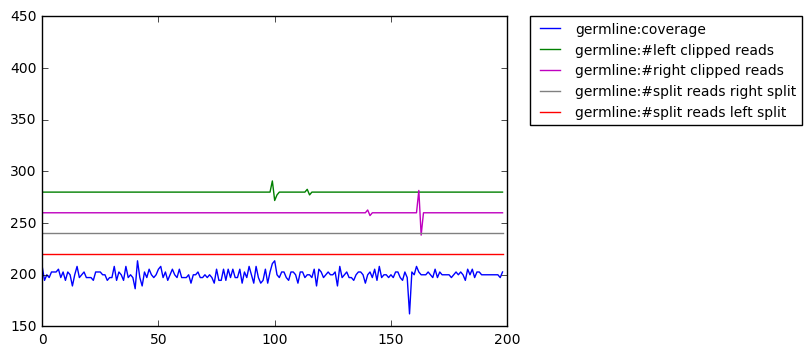

id: 1224
Nanopore: noSV


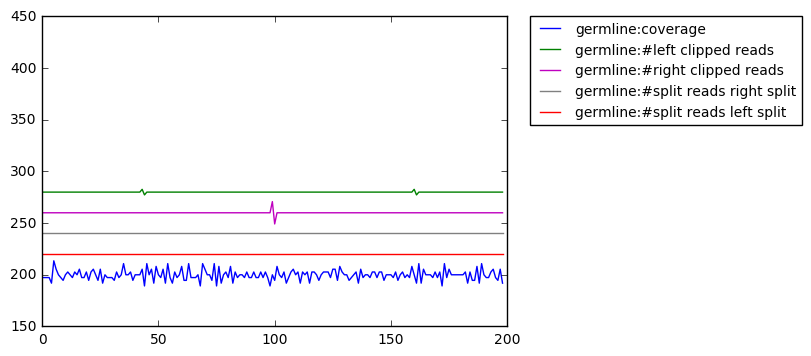

id: 1225
Nanopore: noSV


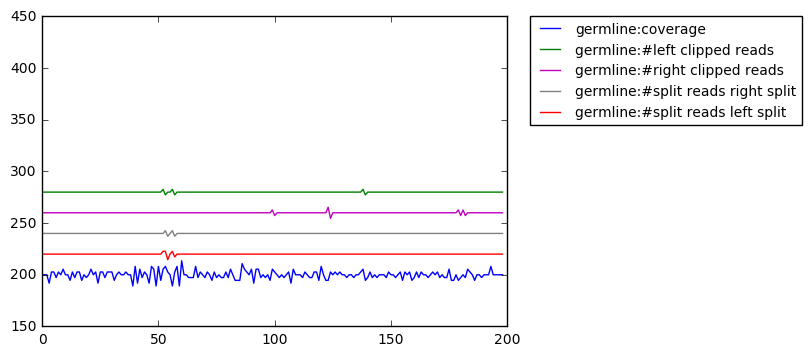

id: 1226
Nanopore: noSV


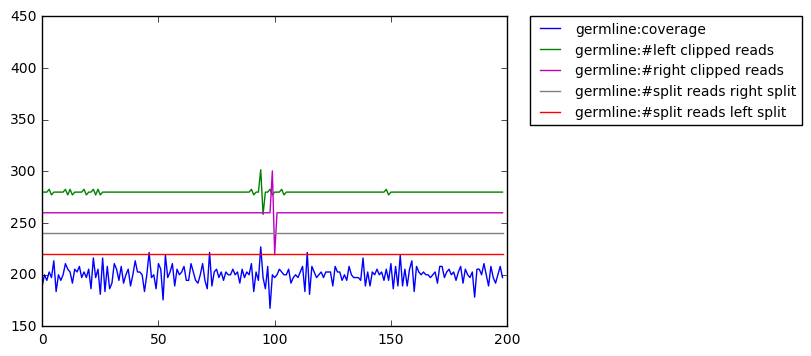

id: 1227
Nanopore: noSV


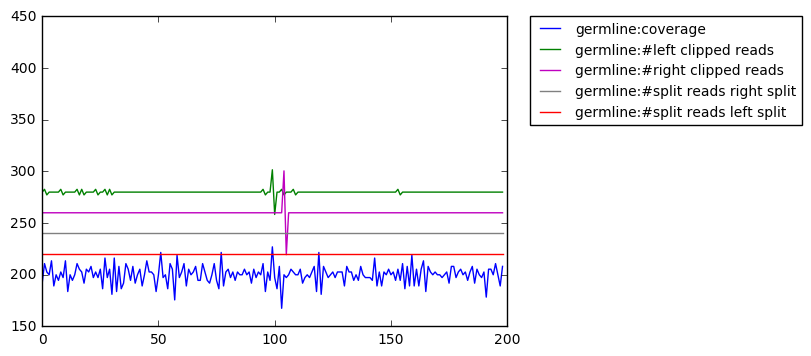

id: 1228
Nanopore: noSV


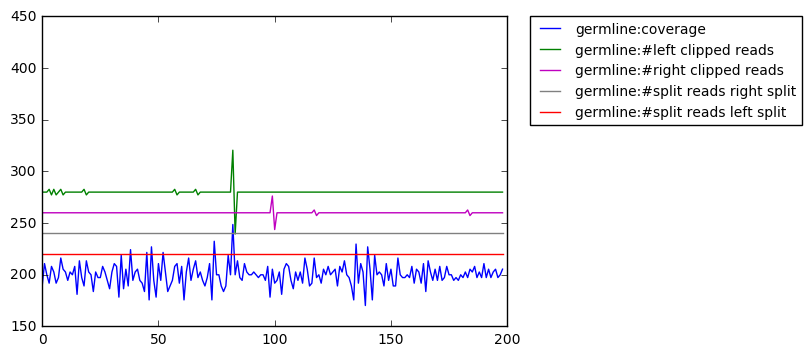

id: 1229
Nanopore: noSV


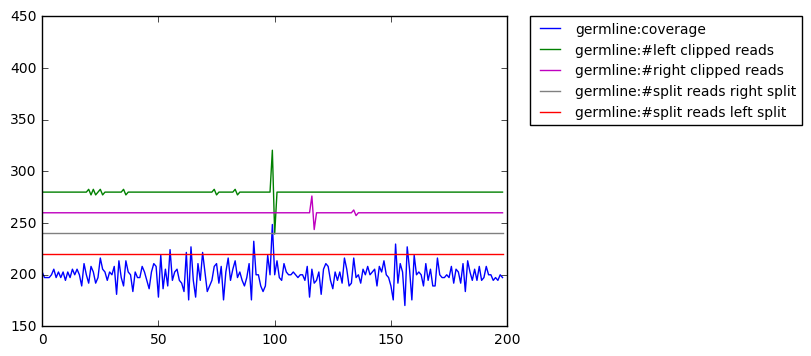

id: 1230
Nanopore: noSV


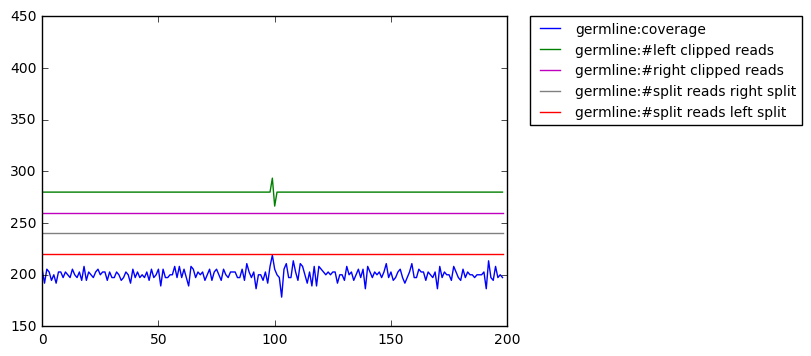

id: 1231
Nanopore: noSV


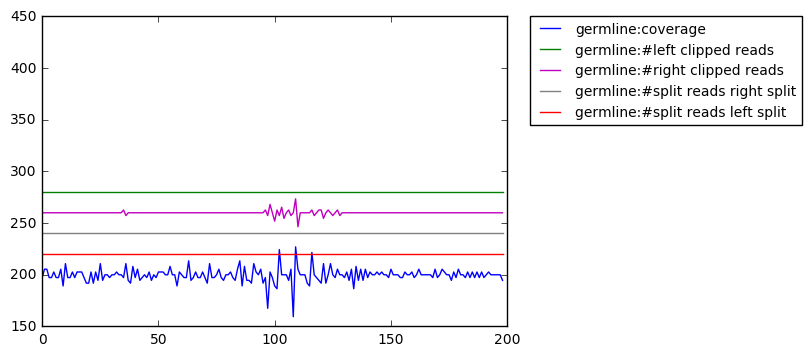

id: 1232
Nanopore: noSV


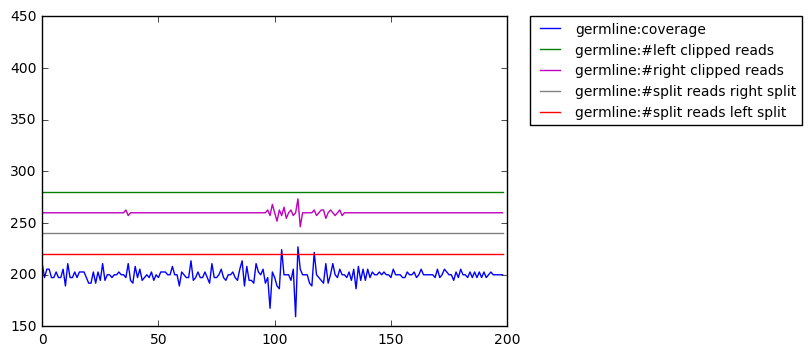

id: 1233
Nanopore: noSV


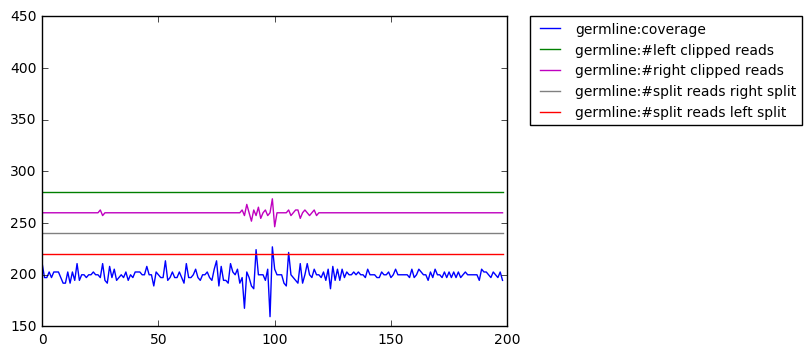

id: 1234
Nanopore: noSV


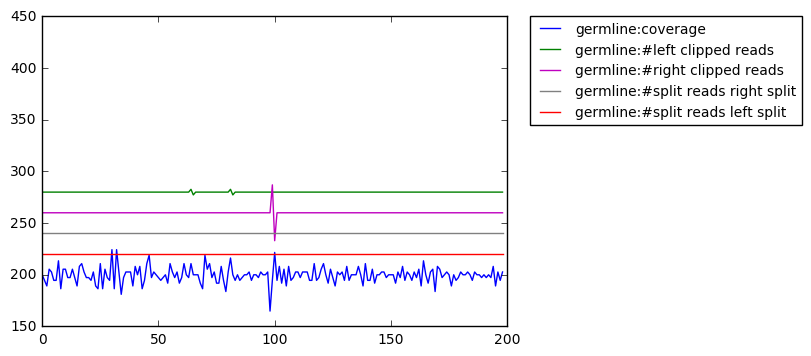

id: 1235
Nanopore: noSV


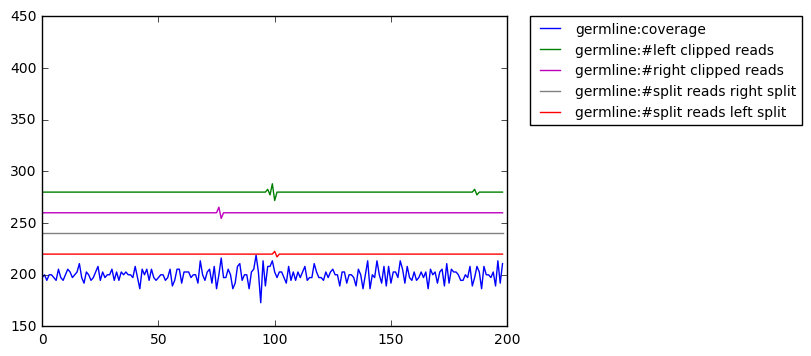

id: 1236
Nanopore: noSV


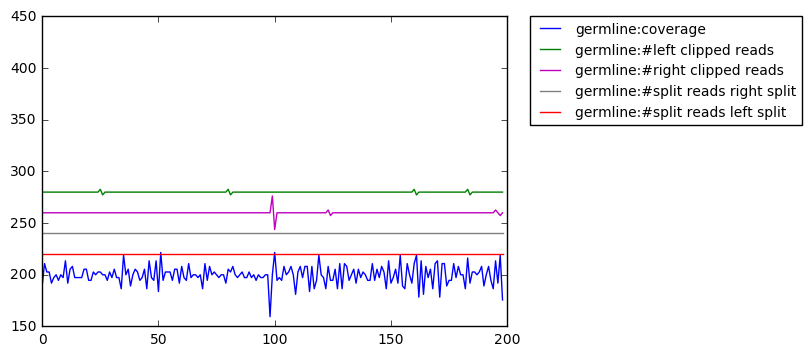

id: 1237
Nanopore: noSV


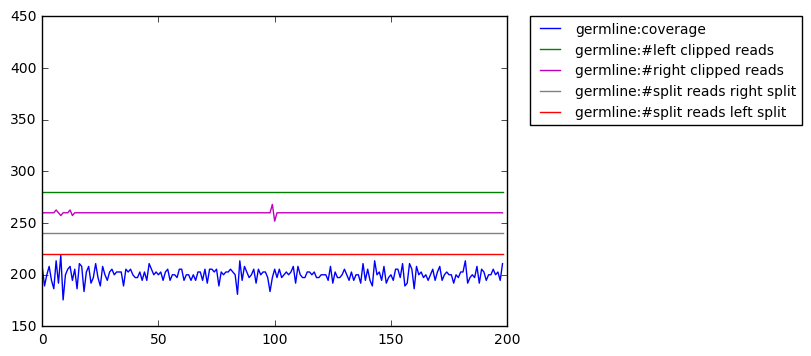

id: 1238
Nanopore: noSV


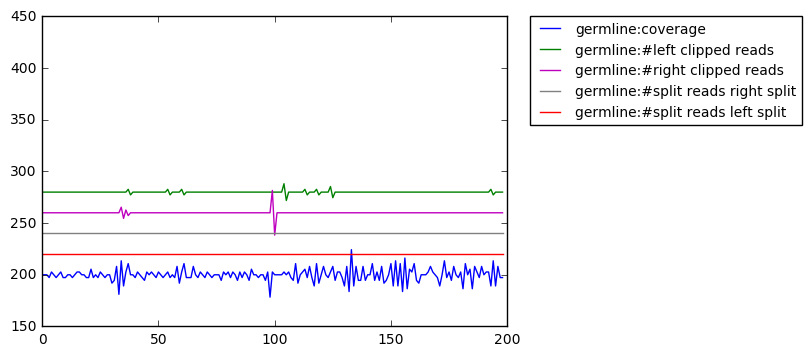

id: 1239
Nanopore: noSV


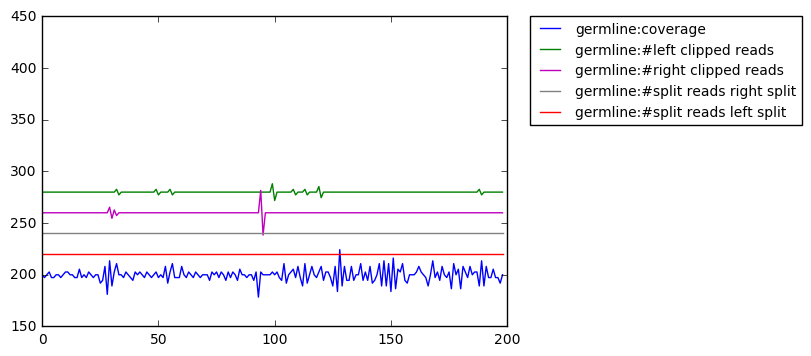

id: 1240
Nanopore: noSV


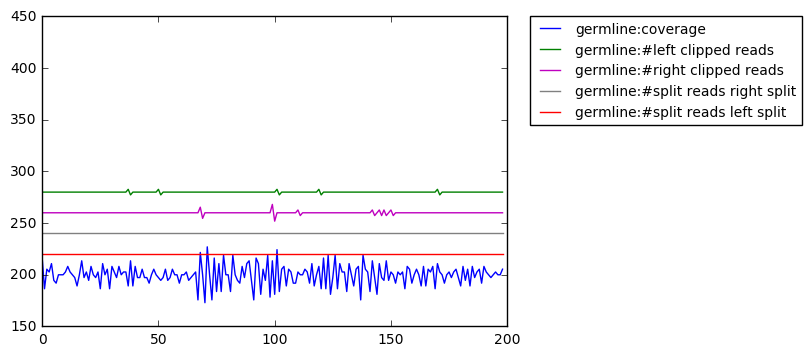

id: 1241
Nanopore: noSV


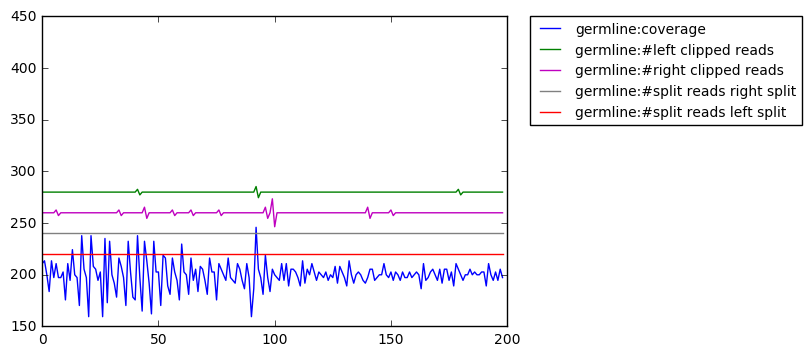

id: 1242
Nanopore: noSV


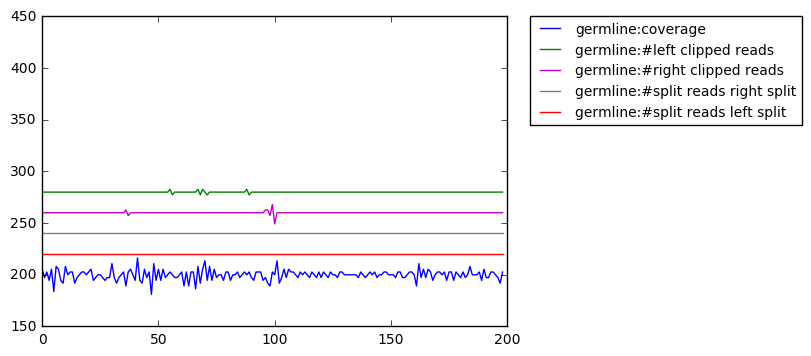

id: 1243
Nanopore: noSV


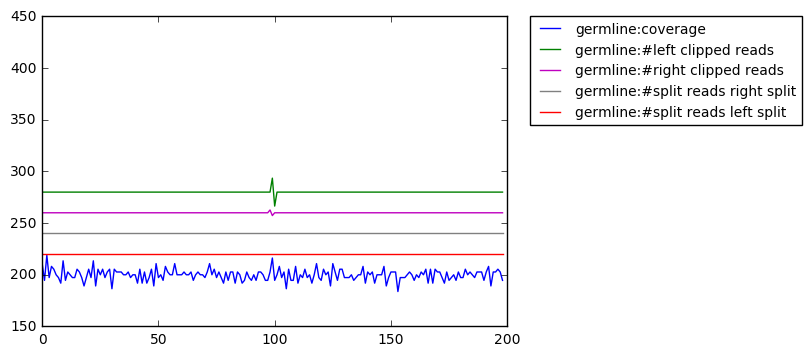

id: 1244
Nanopore: noSV


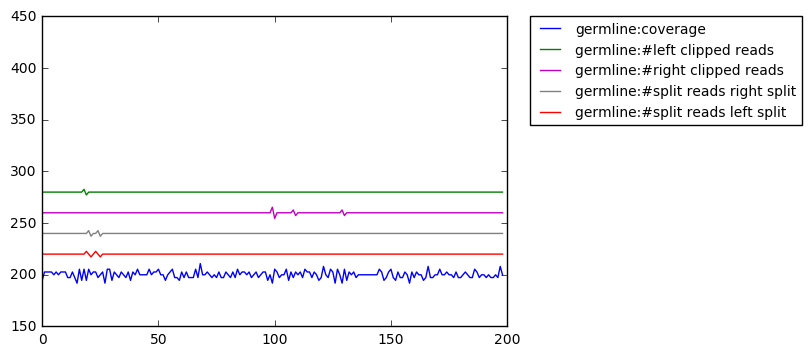

id: 1245
Nanopore: noSV


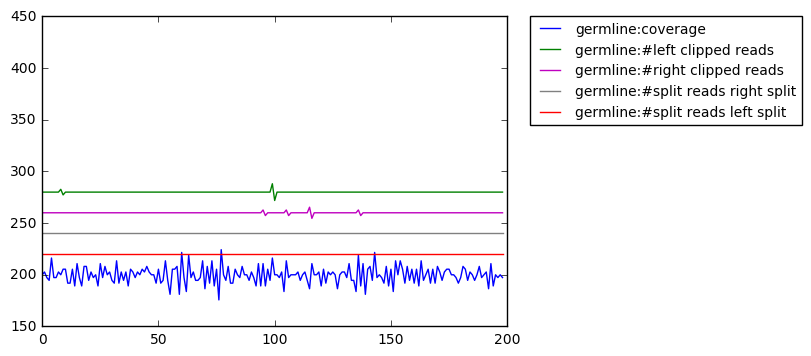

id: 1246
Nanopore: noSV


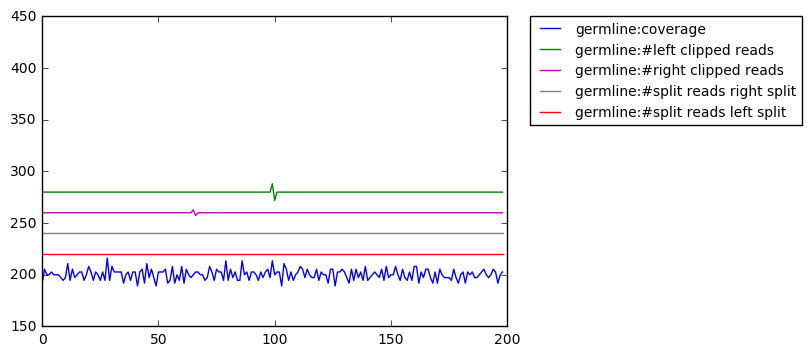

id: 1247
Nanopore: noSV


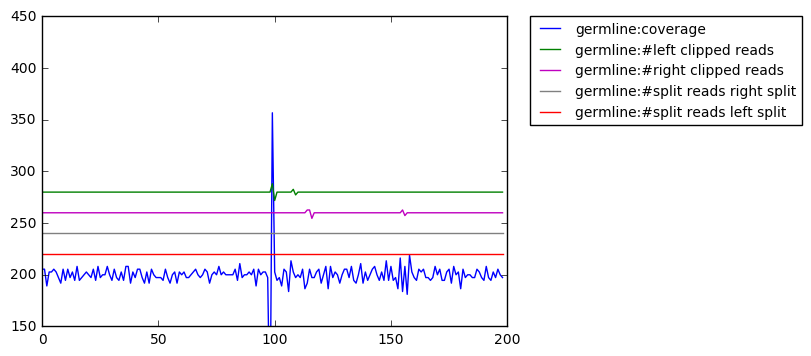

id: 1248
Nanopore: noSV


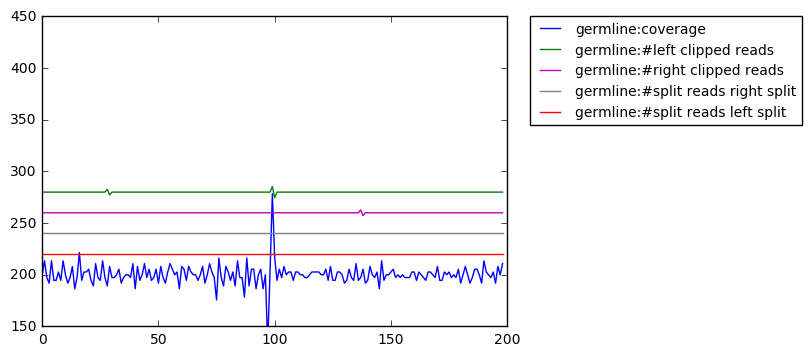

id: 1249
Nanopore: noSV


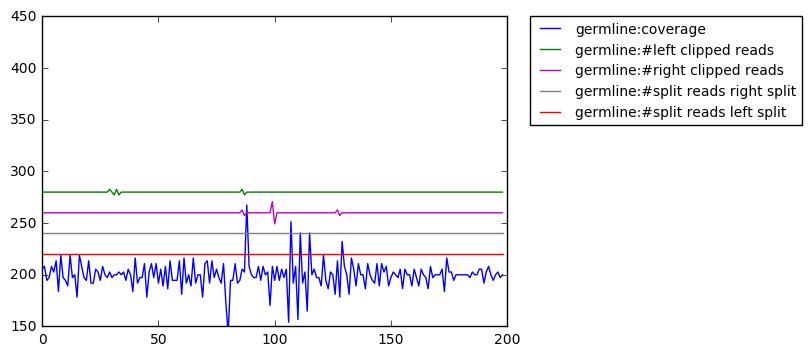

In [50]:
n_windows = 50
start_window = 1200
plot_channels(start_window, n_windows)

   
## Transposes every window in X, to comply to McFly format

In [51]:
def transposeDataset(X):
    image = []
    for i in range (0, len(X -1)):
        tr = X[i].transpose()
        image.append(tr)
    return np.array(image)

image1 = transposeDataset(X_train)
image2 = transposeDataset(X_val)
image3 = transposeDataset(X_test)
X_train = image1
X_val = image2
X_test = image3

n_channels = len(X_train[0][0])
print(len(X_test[0][0]))

5


## Prepare the labels in McFly format

In [52]:
mapclasses = {'DEL_start': 1, 'DEL_end': 0,  'noSV': 2}
print(mapclasses)

{'DEL_start': 1, 'DEL_end': 0, 'noSV': 2}


In [53]:
y_train = np.array([mapclasses[c] for c in y_train], dtype='int')
y_val = np.array([mapclasses[c] for c in y_val], dtype='int')
y_test = np.array([mapclasses[c] for c in y_test], dtype='int')
y_train_binary = to_categorical(y_train)
y_val_binary = to_categorical(y_val)
y_test_binary = to_categorical(y_test)

In [54]:
y_test_binary

array([[ 0.,  1.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       ..., 
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.]])

In [55]:
y_val_binary

array([[ 0.,  1.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       ..., 
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.]])

In [56]:
X_train.shape

(6000, 199, 5)

##  Generate and train neural networks 

In [57]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution1D, Flatten, MaxPooling1D
from keras.optimizers import Adam
import sys
import os
import numpy as np
sys.path.insert(0, os.path.abspath('..'))
from mcfly import modelgen, find_architecture

In [58]:
np.random.seed = 321
num_classes = y_train_binary.shape[1]

%%time
models = modelgen.generate_models(X_train.shape,
                                  num_classes,
                                  number_of_models = 1,
                                  model_type = 'CNN',
                                  cnn_min_layers=1,
                                  cnn_max_layers=1,
                                  cnn_min_filters = 3, 
                                  cnn_max_filters = 3, 
                                  cnn_min_fc_nodes=2, 
                                  cnn_max_fc_nodes=2,
                                  low_lr=1.73, high_lr=1.73,
                                  kernel_size = 11)

In [117]:
%%time
models = modelgen.generate_models(X_train.shape,
                                  num_classes,
                                  number_of_models = 1,
                                  model_type = 'CNN',
                                  cnn_min_layers=2,
                                  cnn_max_layers=2,
                                  cnn_min_filters = 6, 
                                  cnn_max_filters = 6, 
                                  cnn_min_fc_nodes=2, 
                                  cnn_max_fc_nodes=2,
                                  low_lr=2, high_lr=2,
                                  kernel_size = 9)

Wall time: 1 s


In [119]:
%%time
i=0
for model, params, model_types in models:
    print('model ' + str(i))
    i=i+1
    print(params)
    model.summary()

model 0
{'filters': array([6, 6]), 'learning_rate': 0.01, 'fc_hidden_nodes': 2, 'kernel_size': 9, 'regularization_rate': 0.0002917815351670115}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_29 (Batc (None, 199, 5)            20        
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 199, 6)            276       
_________________________________________________________________
batch_normalization_30 (Batc (None, 199, 6)            24        
_________________________________________________________________
activation_29 (Activation)   (None, 199, 6)            0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 199, 6)            330       
_________________________________________________________________
batch_normalization_31 (Batc (None, 199, 6)            24       

In [115]:
train_set_size = X_train.shape[0]
train_set_size

6000

In [120]:
%%time
histories, val_accuracies, val_losses = find_architecture.train_models_on_samples(X_train, y_train_binary,
                                                                                 X_val, y_val_binary,
                                                                                 models,nr_epochs=10, 
                                                                                 subset_size=train_set_size,
                                                                                 verbose=True)

Training model 0 CNN
Train on 6000 samples, validate on 1500 samples
Epoch 1/10
6000/6000 [==============================] - 9s 1ms/step - loss: 0.9105 - acc: 0.5588 - val_loss: 0.9874 - val_acc: 0.4493
Epoch 2/10
6000/6000 [==============================] - 6s 1ms/step - loss: 0.8030 - acc: 0.5907 - val_loss: 1.1954 - val_acc: 0.4507
Epoch 3/10
6000/6000 [==============================] - 6s 1ms/step - loss: 0.7053 - acc: 0.6947 - val_loss: 1.0554 - val_acc: 0.5167
Epoch 4/10
6000/6000 [==============================] - 6s 1ms/step - loss: 0.6598 - acc: 0.7250 - val_loss: 0.8451 - val_acc: 0.6260
Epoch 5/10
6000/6000 [==============================] - 6s 1ms/step - loss: 0.6430 - acc: 0.7373 - val_loss: 1.4799 - val_acc: 0.4107
Epoch 6/10
6000/6000 [==============================] - 6s 1ms/step - loss: 0.6314 - acc: 0.7355 - val_loss: 1.0788 - val_acc: 0.5247
Epoch 7/10
6000/6000 [==============================] - 6s 1ms/step - loss: 0.6187 - acc: 0.7438 - val_loss: 0.7744 - val_acc: 

## Save the best model

In [121]:
best_model_index = np.argmax(val_accuracies)
best_model, best_params, best_model_types = models[best_model_index]
print(best_model_index, best_model_types, best_params)

0 CNN {'filters': array([6, 6]), 'learning_rate': 0.01, 'fc_hidden_nodes': 2, 'kernel_size': 9, 'regularization_rate': 0.0002917815351670115}


In [122]:
from keras.models import load_model

model_path = os.path.join('F:/CNN/notebooks/', 'Gtcg_16_8')

best_model.save(model_path)

## Train the best model on the full dataset

In [ ]:
#We make a copy of the model, to start training from fresh
nr_epochs = 1
datasize = train_set_size # Change in `X_train.shape[0]` if training complete data set
history = best_model.fit(X_train[:datasize,:,:], y_train_binary[:datasize,:],
              epochs=nr_epochs, validation_data=(X_val, y_val_binary))

## Reload the trained model

In [123]:
import os
from keras.models import load_model
model_path = os.path.join('F:/CNN/notebooks/',  'Gtcg_16_8')
model_reloaded = load_model(model_path)

## Inspect model predictions on test data

In [124]:

model = model_reloaded 
datasize = X_test.shape[0]
probs = model.predict_proba(X_test[:datasize,:,:],batch_size=1)

## Columns are predicted labels by DeepSV, rows are nanopore labels

In [125]:
mapclasses = {'DEL_end': 0, 'DEL_start': 1, 'noSV': 2}
dict=mapclasses
dict_sorted = sorted(dict.items(), key=lambda x: x[1])
dict_sorted

[('DEL_end', 0), ('DEL_start', 1), ('noSV', 2)]

In [126]:
labels = [i[0] for i in dict_sorted]

In [127]:
import pandas as pd
predicted = probs.argmax(axis=1)
y_index = y_test_binary.argmax(axis=1)
confusion_matrix = pd.crosstab(pd.Series(y_index), pd.Series(predicted))
confusion_matrix.index = [labels[i] for i in confusion_matrix.index]
confusion_matrix.columns = [labels[i] for i in confusion_matrix.columns]
confusion_matrix.reindex(columns=[l for l in labels], fill_value=0)
confusion_matrix

,DEL_end,DEL_start,noSV
DEL_end,332,16,148
DEL_start,22,369,160
noSV,57,70,396


## Test best current model on testset

### Overall accuracy on the test set:

In [128]:
%%time
score_test = model.evaluate(X_test, y_test_binary, verbose=False)
print('Test loss and accuracy of best model: ' + str(score_test))

Test loss and accuracy of best model: [0.79981159275504432, 0.69872611464968148]
Wall time: 1.19 s
